In [2]:
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
sys.path.insert(0, '../src/')
import zivkovic as z
import coalescentmoments as c
import helpers as h

In [4]:
def fold(n, X):
    i_max = n//2
    k = np.arange(1, n-1)
    multiplicity = 1 + (k == n - k).astype(float)[:i_max]
    if X.ndim == 1:
        folded = (X + X[::-1])[:i_max]
        divisor = multiplicity
    elif X.ndim == 2:
        folded = (X + X[:,::-1] + X[::-1,:] + X[::-1,::-1])[:i_max,:i_max]
        folded[np.diag_indices(i_max)] = 0
        divisor = np.outer(multiplicity, multiplicity)
    return folded / divisor

In [119]:
def stats(n, mode, **params):
    if mode == "kingman":
        xi, xi2 = c.fu_moments(n)
    elif mode in ["exponential", "two-epoch"]:
        xi = z.sigma_i(n, mode, **params)[1:-1]
        xi2 = z.sigma_ij(n, mode, **params)[1:-1,1:-1] + np.outer(xi, xi)
    elif mode == "beta":
        xi, xi2 = c.sfs_moments(n, params["alpha"])
    eta = fold(n, xi)
    eta2 = fold(n, xi2)
    pi = h.sfs2pi(eta, n)
    return eta / pi, eta2 / (pi**2)

In [6]:
def wpmi(eta, eta2, n):
    pi = h.sfs2pi(eta, n)
    ret = eta2 * np.log2(eta2 / np.outer(eta, eta)) / pi**2
    ret[np.diag_indices_from(ret)] = np.nan
    return ret

In [7]:
def lohi_cov(eta, eta2, cutoff=1):
    lo = np.sum(eta[:cutoff])
    hi = np.sum(eta[cutoff:])
    lohi = np.sum(eta2[:cutoff, cutoff:])
    return lohi / (lo*hi) - 1

In [8]:
def lohi_pmi(eta, eta2, cutoff=1):
    return np.log2(lohi_cov(eta, eta2, cutoff=cutoff) + 1)

In [302]:
def tajimasD(n, eta):
    theta_pi = h.sfs2pi(eta, n)
    theta_w  = np.sum(eta) / np.sum(1/np.arange(1,n))
    return (theta_pi - theta_w) / theta_pi

In [10]:
def wpmi_pcolor(ax, mac, wpmi, scale, vm, **kwargs):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    np.fill_diagonal(wpmi, np.nan)
    return ax.pcolormesh(mac, mac, np.arcsinh(wpmi/scale), vmin=-vm, vmax=vm, **kwargs)

def wpmi_colorbar(ax, scale, vm, cmap):
    yticks = np.array([-9, -3, -1, 0, 1, 3, 9])
    yticks_transformed = 256 * (np.arcsinh(yticks) + vm)/(2*vm)
    ax.set_xticks([])
    ax.set_yticks(yticks_transformed)
    ax.set_yticklabels(yticks*scale)
    val = np.linspace(-vm, vm, 256)
    return ax.pcolormesh(val[:,None], cmap=cmap, vmin=-vm, vmax=vm)

# Schematic

In [208]:
def multic_text(x, y, dx, dy, strings, colored=[], ax=None, C0='0.5', C1='0.0'):
    if ax is None:
        ax = plt.gca()
    for i, s in enumerate(strings):
        y_s = y + i*dy
        ax.text(x - 1.5*dx, y_s, '...', fontproperties='monospace', ha='center', va='center', color=C0)
        ax.text(x + (len(s)+.5)*dx, y_s, '...', fontproperties='monospace', ha='center', va='center', color=C0)
        for j, ch in enumerate(s):
            x_c = x + j*dx
            if j in colored:
                col = C1
            else:
                col = C0
            ax.text(x_c, y_s, ch, color=col, fontproperties='monospace', ha='center', va='center')

13


/Users/danielrice/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/Users/danielrice/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


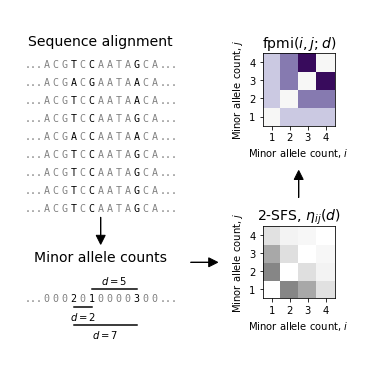

In [263]:
arrow_props = {"head_width":dy/2, "head_length":dy/2, "fc":'k', "ec":'k'}

seq = 'ACG{}C{}AATA{}CA'
alleles1 = 'TTTTATTAT'
alleles2 = 'CCCCCCCGC'
alleles3 = 'GGGGAGAAG'
sequences = [seq.format(*als) for als in zip(alleles1, alleles2, alleles3)]

n_seq = len(alleles1)
len_seq = len(sequences[0])
print(len_seq)


fig = plt.figure(figsize=(5, 5))

ax = fig.add_axes([0, 0, 1, 1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

x = 0.1
y = 0.2
dx = 0.025
dy = 0.05
x_c = x + (len_seq-1)/2*dx

t = ax.text(x_c, y + (5.25+n_seq)*dy, 'Sequence alignment', ha='center', va='center', fontsize=14)
multic_text(x, y + 5*dy, dx, dy, sequences, [3,5, 10], ax=ax)

ax.text(x_c, y + 2.25*dy, 'Minor allele counts', ha='center', va='center', fontsize=14)

counts = '0002010000300'
multic_text(x, y, dx, dy, [counts] , [3,5, 10], ax=ax)

ax.plot([x + 3*dx, x + 5*dx], [y - dy/2, y - dy/2], 'k')
ax.text(x + 4*dx, y - 1*dy, '$d=2$', va='center', ha='center')

ax.plot([x + 3*dx, x + 10*dx], [y - 1.5*dy, y - 1.5*dy], 'k')
ax.text(x + (13/2)*dx, y - 2*dy, '$d=7$', va='center', ha='center')


ax.plot([x + 5*dx, x + 10*dx], [y + dy/2, y + dy/2], 'k')
ax.text(x + (15/2)*dx, y + 1*dy, '$d=5$', va='center', ha='center')

ax.set_xlim([0,1])
ax.set_ylim([0,1])

eta_schem, eta2_schem = stats(8, "kingman")
x2 = 0.7
size = 0.2

ax.arrow(x_c, y + 4.5*dy, 0, -dy, **arrow_props)
ax.arrow(x2+size/2, 0.2+1.4*size, 0, dy, **arrow_props)
ax.arrow(0.5, 0.3, dy, 0, **arrow_props)

ax = fig.add_axes((x2, 0.2, size, size))
ax.pcolormesh(eta2_schem, cmap='Greys', vmin=0, vmax=1.2)
ax.set_yticks(0.5 + np.arange(4))
ax.set_yticklabels(range(1,5))
ax.set_xticks(0.5 + np.arange(4))
ax.set_xticklabels(range(1,5))
ax.set_ylabel('Minor allele count, $j$')
ax.set_xlabel('Minor allele count, $i$')
ax.set_title('2-SFS, $\eta_{ij}(d)$', fontsize=14)


ax = fig.add_axes((x2, 0.68, size, size))
fpmi = np.log(eta2_schem/np.outer(eta_schem, eta_schem))
fpmi[np.diag_indices_from(fpmi)] = 0
ax.pcolormesh(fpmi, cmap='PuOr_r', vmin=-0.5, vmax=0.5)
ax.set_yticks(0.5 + np.arange(4))
ax.set_yticklabels(range(1,5))
ax.set_xticks(0.5 + np.arange(4))
ax.set_xticklabels(range(1,5))
ax.set_ylabel('Minor allele count, $j$')
ax.set_xlabel('Minor allele count, $i$')
ax.set_title('fpmi$(i,j;d)$', fontsize=14)

fig.savefig('../manuscript/figures/schematic.pdf')

# Theory

## Calculations

In [10]:
n_theory = 39
mac_theory = np.arange(1, n_theory//2+1)
alphas = np.linspace(1.25, 1.75, 6)
gs = np.array([0.25, 0.5, 1.0, 2.0, 4.0, 8.0])

In [41]:
print(alphas[1])
print(gs[-2])

1.35
4.0


In [11]:
eta_kingman, eta2_kingman = stats(n_theory, "kingman")

In [12]:
stats_exp = [stats(n_theory, "exponential", g=g) for g in gs]

../src/zivkovic.py:17: RuntimeWarning: invalid value encountered in log
  - loggamma(vec_n + vec_j)
../src/zivkovic.py:17: RuntimeWarning: divide by zero encountered in log
  - loggamma(vec_n + vec_j)
../src/zivkovic.py:73: RuntimeWarning: divide by zero encountered in true_divide
  p = binom(vec_n-vec_i-1, vec_k-2) / binom(vec_n-1, vec_k-1)
../src/zivkovic.py:73: RuntimeWarning: invalid value encountered in true_divide
  p = binom(vec_n-vec_i-1, vec_k-2) / binom(vec_n-1, vec_k-1)
../src/zivkovic.py:54: RuntimeWarning: divide by zero encountered in true_divide
  scaled_x = lag_x[:,None] / x_scale[None,:]
../src/zivkovic.py:44: RuntimeWarning: invalid value encountered in log
  return np.log(1+x*g)/g
../src/zivkovic.py:135: RuntimeWarning: divide by zero encountered in true_divide
  prefactor_ji = sign_ji * (B[:,None] - B[None,:]) / B[:,None]
../src/zivkovic.py:135: RuntimeWarning: invalid value encountered in true_divide
  prefactor_ji = sign_ji * (B[:,None] - B[None,:]) / B[:,None]
..

In [13]:
stats_beta = [stats(n_theory, "beta", alpha=a) for a in alphas]

In [14]:
wpmi_kingman = wpmi(eta_kingman, eta2_kingman, n_theory)
wpmi_exp = [wpmi(eta, eta2, n_theory) for eta, eta2 in stats_exp]
wpmi_beta = [wpmi(eta, eta2, n_theory) for eta, eta2 in stats_beta]

/Users/danielrice/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/danielrice/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
# n = 4
sd_kingman, sd2_kingman = stats(4, "kingman")
sd_exp = [stats(4, "exponential", g=g) for g in gs]
sd_beta = [stats(4, "beta", alpha=a) for a in alphas]

taus = np.logspace(-4, 1, 5, base=2)
fs = np.logspace(-4, -1, 5, base=2)
sd_2ep = [stats(4, "two-epoch", tau=tau, f=f) for f in fs for tau in taus]

../src/zivkovic.py:17: RuntimeWarning: invalid value encountered in log
  - loggamma(vec_n + vec_j)
../src/zivkovic.py:17: RuntimeWarning: divide by zero encountered in log
  - loggamma(vec_n + vec_j)
../src/zivkovic.py:73: RuntimeWarning: divide by zero encountered in true_divide
  p = binom(vec_n-vec_i-1, vec_k-2) / binom(vec_n-1, vec_k-1)
../src/zivkovic.py:73: RuntimeWarning: invalid value encountered in true_divide
  p = binom(vec_n-vec_i-1, vec_k-2) / binom(vec_n-1, vec_k-1)
../src/zivkovic.py:54: RuntimeWarning: divide by zero encountered in true_divide
  scaled_x = lag_x[:,None] / x_scale[None,:]
../src/zivkovic.py:44: RuntimeWarning: invalid value encountered in log
  return np.log(1+x*g)/g
../src/zivkovic.py:135: RuntimeWarning: divide by zero encountered in true_divide
  prefactor_ji = sign_ji * (B[:,None] - B[None,:]) / B[:,None]
../src/zivkovic.py:135: RuntimeWarning: invalid value encountered in true_divide
  prefactor_ji = sign_ji * (B[:,None] - B[None,:]) / B[:,None]
..

## Figures

In [15]:
cmap = 'PuOr_r'
scale = 0.01
vm = 3


/Users/danielrice/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)
/Users/danielrice/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


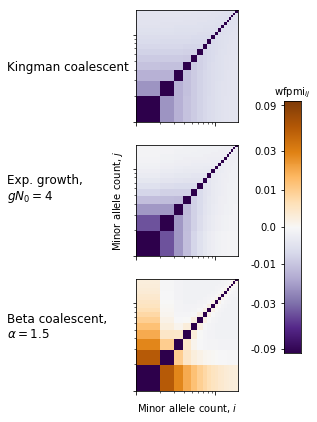

In [365]:
fig = plt.figure(figsize=(4, 7))

ax = fig.add_subplot(3,2,2)
wpmi_pcolor(ax, mac_theory, wpmi_kingman, scale, vm, cmap=cmap)

# ax.set_title('Kingman coalescent')

ax = fig.add_subplot(3,2,4)
wpmi_pcolor(ax, mac_theory, wpmi_exp[-2], scale, vm, cmap=cmap)
# ax.set_title("Exponential growth")
ax.set_ylabel('Minor allele count, $j$')

ax = fig.add_subplot(3,2,6)
wpmi_pcolor(ax, mac_theory, wpmi_beta[2], scale, vm, cmap=cmap)
# ax.set_title("Beta coalescent")
ax.set_xlabel('Minor allele count, $i$')

ax = fig.add_axes([1.06, 0.2, 0.06, 0.5])
wpmi_colorbar(ax, scale, vm, cmap)
# ax.set_title(r'$\pi^{-2} \left<\eta_{ij}\right> fpmi_{ij}$')
ax.set_title('wfpmi$_{ij}$')

x_text = 0.1
fig.text(x_text, 0.66 + 1/10, "Kingman coalescent", fontsize=12)
fig.text(x_text, 0.5, "Exp. growth,\n$gN_0=4$", fontsize=12)
fig.text(x_text, 0.33 - 1/10, "Beta coalescent,\n"+r"$\alpha=1.5$", fontsize=12)

fig.savefig('../manuscript/figures/wfpmi_no_recombination.pdf', bbox_inches="tight")

In [55]:
print(tajimasD(n_theory, stats_exp[-2][0]))
print(tajimasD(n_theory, stats_beta[2][0]))
print(alphas[2])

-0.391494134024
-0.418698125124
1.45


/Users/danielrice/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


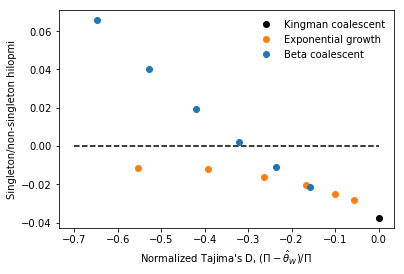

In [367]:
cutoff = 1
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

ax.plot(tajimasD(n_theory, eta_kingman), lohi_pmi(eta_kingman, eta2_kingman, cutoff=cutoff), 'o', c='k',
        label='Kingman coalescent')

for i, stats in enumerate(stats_exp):
    l = ax.plot(tajimasD(n_theory, stats[0]), lohi_pmi(*stats, cutoff=cutoff), 'o', c='C1')
    if i == 0:
        l[0].set_label('Exponential growth')
        
for i, stats in enumerate(stats_beta):
    l = ax.plot(tajimasD(n_theory, stats[0]), lohi_pmi(*stats, cutoff=cutoff), 'o', c='C0')
    if i == 0:
        l[0].set_label("Beta coalescent")

ax.hlines(0, -0.7, 0, linestyle='dashed')
ax.set_ylabel("Singleton/non-singleton hilopmi")
ax.set_xlabel(r"Normalized Tajima's D, $(\Pi - \hat{\theta}_W) / \Pi$")
ax.legend(frameon=False)

fig.savefig('../manuscript/figures/hilopmi_vs_tajimasD_no_recombination.pdf', bbox_inches="tight")

/Users/danielrice/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


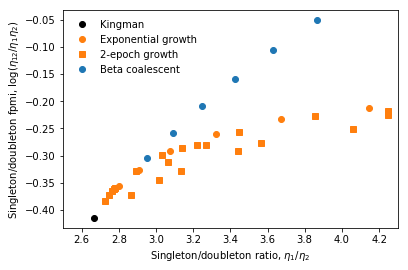

In [363]:
def plot_sd(ax, sd, sd2, *args, **kwargs):
    return ax.plot(sd[0]/sd[1], np.log2(sd2[0,1] / (sd[1]*sd[0])), *args, **kwargs)

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
plot_sd(ax, sd_kingman, sd2_kingman, 'o', c='k', label='Kingman')

for i, (sd, sd2) in enumerate(sd_exp):
    l = plot_sd(ax, sd, sd2, 'o', c='C1')
    if i == 0:
        l[0].set_label("Exponential growth")
for i, (sd, sd2) in enumerate(sd_2ep):
    l = plot_sd(ax, sd, sd2, 's', c='C1')
    if i == 0:
        l[0].set_label("2-epoch growth")

for i, (sd, sd2) in enumerate(sd_beta):
    l = plot_sd(ax, sd, sd2, 'o', c='C0')
    if i == 0:
        l[0].set_label("Beta coalescent")

ax.set_xlim([2.5,4.3])
ax.set_xlabel('Singleton/doubleton ratio, $\eta_1 / \eta_2$')
ax.set_ylabel('Singleton/doubleton fpmi, $\log(\eta_{12} / \eta_1 \eta_2)$')

ax.legend(frameon=False)

fig.savefig('../manuscript/figures/singleton-doubleton.pdf', bbox_inches="tight")

# Simulations

In [11]:
n_sim = 100
mac_sim = np.arange(1, (n_sim+1)//2 + 1)

# Recombination rates
r_list = np.insert(np.logspace(-1,3,13), 0, 0.0)
# Beta coalescent alpha parameter
a_list = [2.0, 1.75, 1.5, 1.25]
# Exp growth parameter
g_list = [1.0, 2.0, 4.0, 8.0]
# Piecewise-constant growth time and factor
t_list = [0.01, 0.1, 1.0]
s_list = [0.2, 0.1, 0.05, 0.01]

In [12]:
prefix = '../simulations/msprime/jsfs_n-{}_'.format(n_sim)

In [266]:
a_kingman = 2.0
a_beta = 1.5
g = 4.0

r_list_kingman = r_list[:-3]
r_list_beta = r_list[:-3]
r_list_exp = r_list[:-3]

file_list_kingman = [prefix + 'a-{}_r-{}.txt'.format(a_kingman, r) for r in r_list_kingman]
file_list_beta = [prefix + 'a-{}_r-{}.txt'.format(a_beta, r) for r in r_list_beta]
file_list_exp = [prefix + 'g-{}_r-{}.txt'.format(g, r) for r in r_list_exp]

data_kingman = h.import_msprime_corr(file_list_kingman, n_sim)
data_beta = h.import_msprime_corr(file_list_beta, n_sim)
data_exp = h.import_msprime_corr(file_list_exp, n_sim)


/Users/danielrice/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)
/Users/danielrice/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


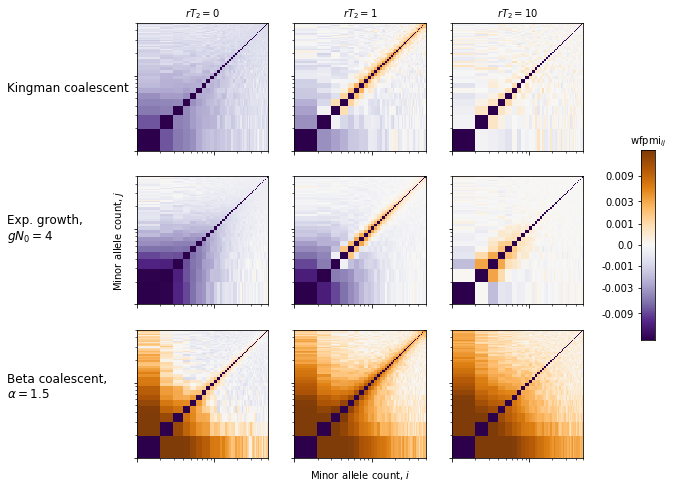

In [361]:
scale_sim = 0.001
vm_sim = 4

fig = plt.figure(figsize=(8,8))
# rT2 = 0
i_0 = 0
# rT2 = 1
i_1 = 4
i_1_exp = 5
# rT2 = 10
i_10 = 7
i_10_exp = 8



ax = plt.subplot(3, 3, 1)
wpmi_pcolor(ax, mac_sim, wpmi(data_kingman[1][i_0], data_kingman[2][i_0], n_sim), scale_sim, vm_sim, cmap=cmap)
ax.set_title('$rT_2 = 0$')
#ax.set_ylabel('Minor allele count, $j$')
ax = plt.subplot(3, 3, 2)
wpmi_pcolor(ax, mac_sim, wpmi(data_kingman[1][i_1], data_kingman[2][i_1], n_sim), scale_sim, vm_sim, cmap=cmap)
ax.set_title('$rT_2 = 1$')
ax = plt.subplot(3, 3, 3)
wpmi_pcolor(ax, mac_sim, wpmi(data_kingman[1][i_10], data_kingman[2][i_10], n_sim), scale_sim, vm_sim, cmap=cmap)
ax.set_title('$rT_2 = 10$')


ax = plt.subplot(3, 3, 4)
wpmi_pcolor(ax, mac_sim, wpmi(data_exp[1][i_0], data_exp[2][i_0], n_sim), scale_sim, vm_sim, cmap=cmap)
ax.set_ylabel('Minor allele count, $j$')
ax = plt.subplot(3, 3, 5)
wpmi_pcolor(ax, mac_sim, wpmi(data_exp[1][i_1_exp], data_exp[2][i_1_exp], n_sim), scale_sim, vm_sim, cmap=cmap)
ax = plt.subplot(3, 3, 6)
wpmi_pcolor(ax, mac_sim, wpmi(data_exp[1][i_10_exp], data_exp[2][i_10_exp], n_sim), scale_sim, vm_sim, cmap=cmap)

ax = plt.subplot(3, 3, 7)
wpmi_pcolor(ax, mac_sim, wpmi(data_beta[1][i_0], data_beta[2][i_0], n_sim), scale_sim, vm_sim, cmap=cmap)
ax = plt.subplot(3, 3, 8)
wpmi_pcolor(ax, mac_sim, wpmi(data_beta[1][i_1], data_beta[2][i_1], n_sim), scale_sim, vm_sim, cmap=cmap)
ax.set_xlabel('Minor allele count, $i$')
ax = plt.subplot(3, 3, 9)
wpmi_pcolor(ax, mac_sim, wpmi(data_beta[1][i_10], data_beta[2][i_10], n_sim), scale_sim, vm_sim, cmap=cmap)

ax = fig.add_axes([1, 0.33, 0.025, 0.33])
wpmi_colorbar(ax, scale_sim, vm_sim, cmap=cmap)
ax.set_title('wfpmi$_{ij}$')

fig.text(-0.1, 0.66 + 1/10, "Kingman coalescent", fontsize=12)
fig.text(-0.1, 0.33 - 1/10, "Beta coalescent,\n"+r"$\alpha=1.5$", fontsize=12)
fig.text(-0.1, 0.5, "Exp. growth,\n$gN_0=4$", fontsize=12)

fig.savefig('../manuscript/figures/wfpmi_with_recombination.pdf', bbox_inches="tight")

In [307]:
def plot_lohi_vs_td(axes, r_list, file_list, cutoff_list, n_samples, **kwargs):
    pi, sfs, jsfs, pi_corr, lolo_corr, lohi_corr, hihi_corr = h.import_msprime_corr(file_list, n_samples)
    i_r = np.nanargmin(np.abs(np.log(pi*r_list/2)))
    td = tajimasD(n_samples, sfs[i_r])
    for i_cutoff, cutoff in enumerate(cutoffs):
        axes[i_cutoff].plot(td, lohi_corr[i_r][cutoff-1], **kwargs)

/Users/danielrice/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/danielrice/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


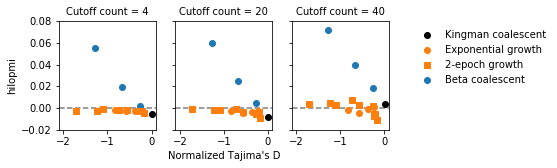

In [366]:
fig = plt.figure(figsize=(8,2))
cutoffs = [4, 20, 40]
axes = [plt.subplot(1, len(cutoffs)+1, i+1) for i in range(len(cutoffs))]

for i_a, alpha in enumerate(a_list):
    if i_a == 0:
        c = 'k'
    else:
        c = 'C0'
    rl = r_list_beta
    files = [prefix + 'a-{}_r-{}.txt'.format(alpha, r) for r in rl]
    plot_lohi_vs_td(axes, rl, files, cutoffs, n_sim, color=c, marker='o')
    
for g in g_list:
    rl = r_list_exp
    files = [prefix + 'g-{}_r-{}.txt'.format(g, r) for r in rl]
    plot_lohi_vs_td(axes, rl, files, cutoffs, n_sim, color='C1', marker='o')
    
for t in t_list:
    for s in s_list:
        rl = r_list
        files = [prefix + 'T-{}_S-{}_r-{}.txt'.format(t,s,r) for r in rl]
        plot_lohi_vs_td(axes, rl, files, cutoffs, n_sim, color='C1', marker='s')

for i_ax, ax in enumerate(axes):
    xlims = [-2.1,0.1]
    ax.hlines(0, xlims[0], xlims[1], linestyle='dashed', color='.5')
    ax.set_xlim(xlims)
    ax.set_ylim([-0.02,0.08])
    ax.set_title('Cutoff count = {}'.format(cutoffs[i_ax]))
    if i_ax == 0:
        ax.set_ylabel('hilopmi')
    else:
        ax.set_yticklabels([])
axes[1].set_xlabel("Normalized Tajima's D")

legend_axes = fig.add_subplot(1, len(cutoffs)+1, len(cutoffs)+1)
legend_axes.plot([],[], 'ok', label='Kingman coalescent')
legend_axes.plot([],[], 'C1o', label='Exponential growth')
legend_axes.plot([],[], 'C1s', label='2-epoch growth')
legend_axes.plot([],[], 'C0o', label='Beta coalescent')
legend_axes.legend(loc='upper left')
legend_axes.set_xticks([])
legend_axes.set_yticks([])
legend_axes.spines['right'].set_visible(False)
legend_axes.spines['top'].set_visible(False)
legend_axes.spines['left'].set_visible(False)
legend_axes.spines['bottom'].set_visible(False)

fig.savefig('../manuscript/figures/hilopmi_vs_tajimasD_recombination.pdf', bbox_inches='tight')